In [1]:
from utils import *

from scipy import signal
import matplotlib.pyplot as plt
import librosa
import python_speech_features
import math
import numpy as np
from tqdm import tqdm
from pysndfx import AudioEffectsChain

/Users/user/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/user/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
PROJECT_DIR = get_upper_dir()
DATA_DIR = get_data_noise_dir(PROJECT_DIR)

In [3]:
name_list = extract_file_name(DATA_DIR)

In [4]:
def band_butter_pass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [5]:
def band_butter_filter(data, lowcut, highcut, fs):
    b, a = band_butter_pass(lowcut, highcut, fs)
    y = signal.lfilter(b, a, data)
    return y

In [6]:
def reduce_noise_centroid_mb(y, sr):
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent)

    less_noise = AudioEffectsChain().lowshelf(gain=-12.0, frequency=threshold_l, slope=0.5).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5).limiter(gain=6.0)

    y_cleaned = less_noise(y)

    return y_cleaned


    #return y_clean_boosted

In [7]:
def reduce_noise_mfcc_up(y, sr):

    hop_length = 512

    mfcc = python_speech_features.base.mfcc(y)
    mfcc = python_speech_features.base.logfbank(y)
    mfcc = python_speech_features.base.lifter(mfcc)

    sum_of_squares = []
    index = -1
    for r in mfcc:
        sum_of_squares.append(0)
        index = index + 1
        for n in r:
            sum_of_squares[index] = sum_of_squares[index] + n**2

    strongest_frame = sum_of_squares.index(max(sum_of_squares))
    hz = python_speech_features.base.mel2hz(mfcc[strongest_frame])

    max_hz = max(hz)
    min_hz = min(hz)

    speech_booster = AudioEffectsChain().lowshelf(frequency=min_hz*(-1), gain=12.0, slope=0.5)#.highshelf(frequency=min_hz*(-1)*1.2, gain=-12.0, slope=0.5)#.limiter(gain=8.0)
    y_speach_boosted = speech_booster(y)

    return (y_speach_boosted)

In [8]:
def reduce_noise_power(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = round(np.median(cent))*1.5
    threshold_l = round(np.median(cent))*0.1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.8).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5)#.limiter(gain=6.0)
    y_clean = less_noise(y)

    return y_clean

In [30]:
def noise_reduction(x, sr, lowpass, highpass):
    y = band_butter_filter(x, lowpass, highpass, sr)
    y_mfcc_up = reduce_noise_mfcc_up(y, sr)
    y_centroid = reduce_noise_centroid_mb(y_mfcc_up, sr)
    y_cleaned = reduce_noise_power(y, sr)
    
    return y_cleaned

In [31]:
lowpass = 1700
highpass = 2300

for name in tqdm(name_list):
    ch1_name = DATA_DIR + '/' + name + '_ch1.wav'
    ch2_name = DATA_DIR + '/' + name + '_ch2.wav'
    x1, fs1 = librosa.load(ch1_name)
    x2, fs2 = librosa.load(ch2_name)
    
    y1 = noise_reduction(x1, fs1, lowpass, highpass)
    save_wav(y1, fs1, name, '_ch1.wav', PROJECT_DIR)

    y2 = noise_reduction(x2, fs2, lowpass, highpass)
    save_wav(y2, fs2, name, '_ch2.wav', PROJECT_DIR)

100%|██████████| 1800/1800 [08:28<00:00,  3.54it/s]


In [14]:
import librosa.display

In [40]:
lowpass = 1700
highpass = 2300
x1, fs1 = librosa.load(DATA_DIR + '/' + name_list[140] + '_ch1.wav')
y1 = noise_reduction(x1, fs1, lowpass, highpass)

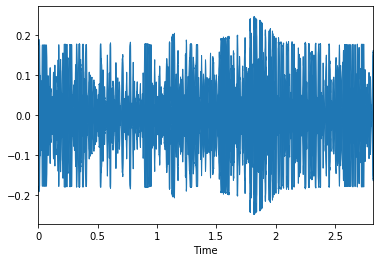

In [41]:
librosa.display.waveplot(x1, sr=fs1)

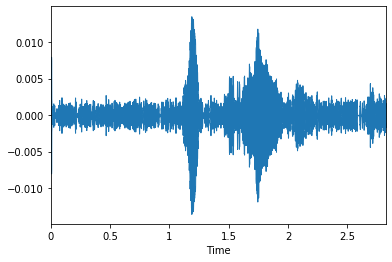

In [42]:
librosa.display.waveplot(y1, sr=fs1)

In [25]:
x2, fs2 = librosa.load(DATA_DIR + '/' + name_list[190] + '_ch1.wav')
y2 = noise_reduction(x2, fs2, lowpass, highpass)

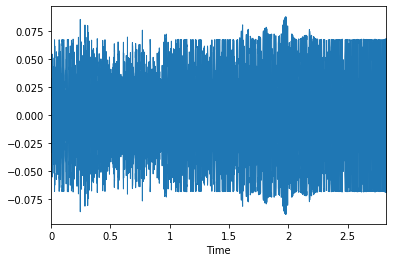

In [26]:
librosa.display.waveplot(x1, sr=fs1)

In [20]:
name_list[190]

'data_709_46_angle_040'

In [ ]:
librosa.display.waveplot(z1, sr=fs1)

In [ ]:
name

In [12]:
len(name_list)

2400